In [1]:
from dotenv import load_dotenv
import os
# .env 파일을 불러와서 환경 변수로 설정
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
WA


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_upstage import UpstageEmbeddings, ChatUpstage

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

from IPython.display import Image, display
from typing import List


In [3]:

# Vector DB 초기화 (카페 메뉴 DB)
#embeddings_model = OllamaEmbeddings(model="bge-m3:latest")
embeddings_model = UpstageEmbeddings(model="solar-embedding-1-large")

cafe_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# 1단계: 카페 메뉴 검색 도구 정의
@tool
def search_cafe_menu(query: str) -> str:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=6)
    
    formatted_docs = "\n\n---\n\n".join([
        f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
        for doc in docs
    ])
    
    if len(docs) > 0:
        return formatted_docs
    return "관련 카페 메뉴 정보를 찾을 수 없습니다."

# 2단계: 상태 정의
class AgentState(MessagesState):
    """ReAct Agent의 상태를 정의하는 클래스"""
    pass

In [4]:

# 3단계: LLM과 도구 설정
#llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
# llm = ChatOpenAI(
#     #api_key=OPENAI_API_KEY,
#     base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
#     model="meta-llama/llama-4-scout-17b-16e-instruct",
#     temperature=0.7
# )
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5,
)
print(llm.model_name)

tools = [search_cafe_menu]
llm_with_tools = llm.bind_tools(tools=tools)

# 4단계: 시스템 프롬프트 정의
system_prompt = """
당신은 카페의 AI 어시스턴트입니다. 고객의 메뉴 관련 질문에 정확하고 친절하게 답변해주세요.

다음 도구를 사용할 수 있습니다:
- search_cafe_menu: 카페 메뉴 정보를 검색할 때 사용하세요

고객의 질문을 이해하고, 필요한 경우 도구를 사용하여 정보를 찾은 후 정확한 답변을 제공하세요.
"""

# 5단계: 노드 함수들 정의
def call_model(state: AgentState):
    """LLM을 호출하여 응답을 생성하는 노드"""
    print("--- Agent 노드: LLM 호출 ---")
    
    # 시스템 메시지 추가
    messages = [SystemMessage(content=system_prompt)] + state['messages']
    response = llm_with_tools.invoke(messages)
    
    print(f"LLM 응답 생성 완료. 도구 호출 여부: {bool(response.tool_calls)}")
    
    return {"messages": [response]}

solar-pro


In [5]:

# 6단계: 그래프 구성
builder = StateGraph(AgentState)

# 노드 추가
builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

# 엣지 추가
builder.add_edge(START, "agent")

# 조건부 엣지: tools_condition 사용
builder.add_conditional_edges(
    "agent",
    tools_condition,  # 자동으로 도구 호출 여부 판단
)

# 도구 실행 후 다시 agent로 돌아가기
builder.add_edge("tools", "agent")

# 7단계: 그래프 컴파일
custom_react_agent = builder.compile()

print("사용자 정의 ReAct Agent가 성공적으로 생성되었습니다!")
print(f"Agent 타입: {type(custom_react_agent)}")

사용자 정의 ReAct Agent가 성공적으로 생성되었습니다!
Agent 타입: <class 'langgraph.graph.state.CompiledStateGraph'>


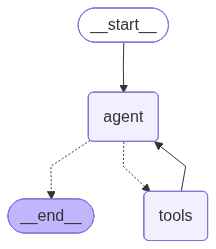

In [6]:
# 8단계: 그래프 시각화
try:
    display(Image(custom_react_agent.get_graph().draw_mermaid_png()))
except:
    print("그래프 시각화를 건너뜁니다.")

In [ ]:

# 9단계: Agent 테스트 함수
def test_custom_react_agent():
    """사용자 정의 ReAct Agent 테스트"""
    test_questions = [
        "아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.",
        "라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?",
        "디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요."
    ]
    
    for question in test_questions:
        print(f"\n{'='*60}")
        print(f"질문: {question}")
        print('='*60)
        
        # Agent 실행
        inputs = {"messages": [HumanMessage(content=question)]}
        result = custom_react_agent.invoke(inputs)
        
        # 실행 과정 출력
        print("\n=== 실행 과정 ===")
        for i, message in enumerate(result['messages']):
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"{i+1}. {type(message).__name__}: 도구 호출 - {message.tool_calls[0]['name']}")
            else:
                content_preview = message.content[:100] + "..." if len(message.content) > 100 else message.content
                print(f"{i+1}. {type(message).__name__}: {content_preview}")
        
        # 최종 답변 출력
        print(f"\n=== 최종 답변 ===")
        print(result['messages'][-1].content)


In [8]:

# 10단계: 단일 테스트 실행
print("\n=== 단일 테스트 ===")
inputs = {"messages": [HumanMessage(content="콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?")]}
result = custom_react_agent.invoke(inputs)


=== 단일 테스트 ===
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: True
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False


In [9]:

print("\n=== 메시지 흐름 분석 ===")
for i, message in enumerate(result['messages']):
    print(f"{i+1}. {type(message).__name__}")
    if hasattr(message, 'tool_calls') and message.tool_calls:
        print(f"   - 도구 호출: {message.tool_calls[0]['name']} with '{message.tool_calls[0]['args']['query']}'")
    else:
        content_preview = message.content[:150] + "..." if len(message.content) > 150 else message.content
        print(f"   - 내용: {content_preview}")

print(f"\n=== 최종 답변 ===")
print(result['messages'][-1].content)



=== 메시지 흐름 분석 ===
1. HumanMessage
   - 내용: 콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?
2. AIMessage
   - 도구 호출: search_cafe_menu with '콜드브루 아이스 아메리카노 메뉴 정보'
3. ToolMessage
   - 내용: <Document source="../data/cafe_menu_data.txt"/>
6. 콜드브루
   • 가격: ₩5,000
   • 주요 원료: 콜드브루 원액, 차가운 물
   • 설명: 찬물에 12-24시간 우려낸 콜드브루 원액을 사용한 시원한 커피입니다. 부드...
4. AIMessage
   - 내용: 카페 메뉴 정보를 바탕으로 **콜드브루**와 **아이스 아메리카노**의 차이점을 정리해드리겠습니다.  

### 1. **추출 방식**  
- **콜드브루**: 찬물로 12~24시간 장시간 추출하여 부드럽고 단맛이 강조됩니다.  
- **아이스 아메리카노**: 뜨거운 ...

=== 최종 답변 ===
카페 메뉴 정보를 바탕으로 **콜드브루**와 **아이스 아메리카노**의 차이점을 정리해드리겠습니다.  

### 1. **추출 방식**  
- **콜드브루**: 찬물로 12~24시간 장시간 추출하여 부드럽고 단맛이 강조됩니다.  
- **아이스 아메리카노**: 뜨거운 물로 빠르게 추출한 에스프레소를 차가운 물과 얼음에 희석합니다.  

### 2. **맛과 향**  
- **콜드브루**: 산미가 적고 부드러운 단맛이 특징이며, 쓴맛이 덜합니다.  
- **아이스 아메리카노**: 에스프레소의 진한 향과 산미, 쓴맛이 살아있어 깔끔한 뒷맛이 느껴집니다.  

### 3. **재료**  
- **콜드브루**: 콜드브루 원액 + 차가운 물 + 얼음  
- **아이스 아메리카노**: 에스프레소 + 차가운 물 + 얼음  

### 4. **가격**  
- **콜드브루**: ₩5,000  
- **아이스 아메리카노**: ₩4,500  

### 5. **추천 상황**  
-

In [10]:

# 11단계: 전체 테스트 실행
print("\n=== 전체 테스트 실행 ===")
test_custom_react_agent()


=== 전체 테스트 실행 ===

질문: 아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: True
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

=== 실행 과정 ===
1. HumanMessage: 아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
2. AIMessage: 도구 호출 - search_cafe_menu
3. ToolMessage: <Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 ...
4. AIMessage: 아메리카노와 아이스 아메리카노의 차이점과 가격은 다음과 같습니다:

1. **차이점**  
   - **아메리카노**: 뜨거운 에스프레소에 따뜻한 물을 섞어 만든 **핫 커피**입...

=== 최종 답변 ===
아메리카노와 아이스 아메리카노의 차이점과 가격은 다음과 같습니다:

1. **차이점**  
   - **아메리카노**: 뜨거운 에스프레소에 따뜻한 물을 섞어 만든 **핫 커피**입니다. 원두의 풍미를 가장 잘 느낄 수 있으며, 깔끔하고 깊은 맛이 특징입니다.  
   - **아이스 아메리카노**: 뜨거운 에스프레소에 **차가운 물과 얼음**을 넣어 만든 **아이스 커피**입니다. 시원한 온도에서 즐길 수 있으며, 더운 날씨에 인기 있는 메뉴입니다.  

2. **가격**  
   - 두 메뉴 모두 **₩4,500**으로 동일합니다.  

3. **추가 정보**  
   - 아이스 아메리카노는 얼음이 녹는 것을 고려해 더 진한 에스프레소를 사용하는 경우가 많으나, 본 카페에서는 동일한 원액과 레시피를 사용합니다.  
   - 설탕이나 시럽 추가는 두 메뉴 모두 가능합니다.  

더 궁금한 사항이 있으면 언제든 질문해주세요! ☕

질문: 라떼